In [23]:
# import library
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import keras
import visualkeras
import graphviz
from keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from kerastuner import HyperParameters
import kerastuner as kt
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model


import warnings
warnings.filterwarnings('ignore')

# Load Data Subset based on Class Imbalance Analysis
*Data Source: [Fashion Product Images (Small)](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small)*

Text(0.5, 1.0, 'Class Distribution')

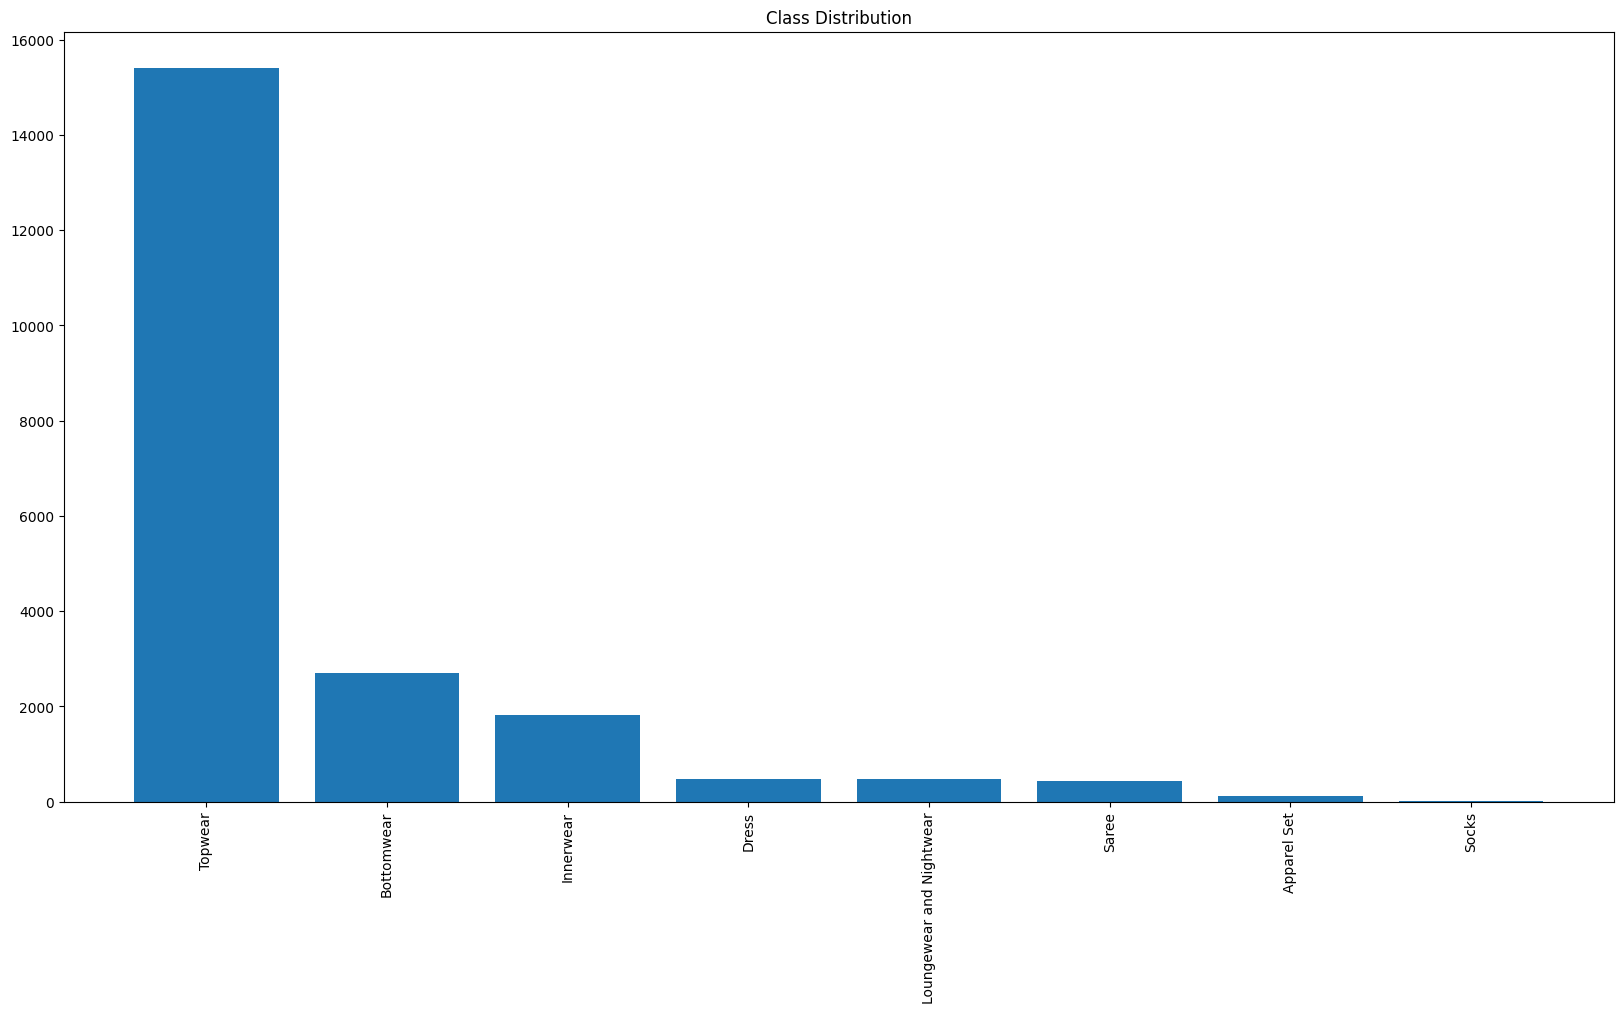

In [2]:
# Load label data
df_full = pd.read_csv('Fashion/styles.csv', on_bad_lines='skip')
apparel_df = df_full[df_full['masterCategory'] == 'Apparel']

# plot class distribution
plt.figure(figsize=(20, 10))
plt.bar(apparel_df['subCategory'].value_counts().index, apparel_df['subCategory'].value_counts())
plt.xticks(rotation=90)
plt.title('Class Distribution')

In [3]:
# Subsample the data: pick 400 samples from each class
sub_df1 = apparel_df[~apparel_df.subCategory.isin(['Apparel Set', 'Socks'])]
sub_df2 = pd.DataFrame()
for i in sub_df1['subCategory'].unique():
    cat_df = apparel_df[apparel_df['subCategory'] == i].sample(400)
    sub_df2 = pd.concat([sub_df2, cat_df])
sub_df2['subCategory'].value_counts()

subCategory
Topwear                     400
Bottomwear                  400
Innerwear                   400
Saree                       400
Dress                       400
Loungewear and Nightwear    400
Name: count, dtype: int64

In [4]:
# Stratified train-test split
sub_df2 = sub_df2[['id','subCategory']]
sub_df2['img_path'] = sub_df2['id'].apply(lambda x: 'Fashion/images/' + str(x) + '.jpg')
train_df, test_df = train_test_split(sub_df2, test_size=0.2, stratify=sub_df2["subCategory"], random_state=42)

In [5]:
# load in training and testing data according the to path
def preprocess_images(df, image_size = None):
    images = []
    labels = []
    for index, row in df.iterrows():
        path = row['img_path']
        label = row['subCategory']
        # Load the image
        image = Image.open(path)
        # Remove invalid data
        if np.array(image).shape != (80,60,3):
            continue
        # Resize the image
        if image_size != None:
            image = image.resize(image_size)
        # Convert the image to numpy array
        image = np.array(image)
        # Normalize the image
        image = image.astype('float32') / 255.0
        # Add the image and label to the lists
        images.append(image)
        labels.append(label)
    # Convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

x_train, y_train = preprocess_images(train_df)
x_test, y_test = preprocess_images(test_df)
print("X_train shape: ", x_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", x_test.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (1906, 80, 60, 3)
Y_train shape:  (1906,)
X_test shape:  (478, 80, 60, 3)
Y_test shape:  (478,)


# EDA
### Visualize images


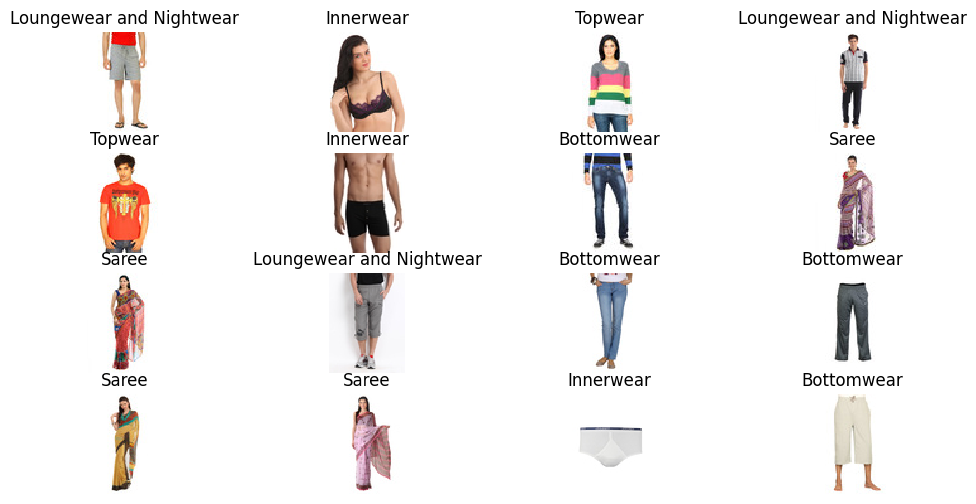

In [8]:
# visualize training images and and label
images_and_labels = list(zip(x_train, y_train))
plt.figure(figsize=(12, 6))
for index, (image, label) in enumerate(images_and_labels[:16]):
    plt.subplot(4,4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label == 1)
    plt.title(label)
plt.show()

# Model Training and Evaluation

In [6]:
# Encode the labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [7]:
# Set up constants
num_classes = 6
input_shape = (80, 60, 3)

### Custom Model
#### Hyperparameter Tuning

In [9]:
# Define model architecture and the hyperparameter search space
def build_model(hp):
    model = keras.Sequential()
    
    # Tune the number of filters in the Conv2D layer
    #hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

    # Tune the pooling size
    hp_pooling = hp.Int('pooling', min_value=2, max_value=4, step=1)
    model.add(layers.MaxPooling2D(pool_size=hp_pooling))

    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout))

    model.add(layers.Flatten())

    # Tune the number of neurons in the Dense layer
    hp_neurons = hp.Int('neurons', min_value=16, max_value=64, step=16)
    model.add(layers.Dense(units=hp_neurons, activation='relu'))
    model.add(layers.Dense(units=10, activation='softmax'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=hp_learning_rate),metrics =['accuracy'])
    
    return model

# Conduct the hyperparameter search
hp = HyperParameters()
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project')

tuner.search(x_train, y_train_encoded, epochs=50, batch_size = 20,validation_split=0.2)


Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.8455497622489929

Best val_accuracy So Far: 0.8586387634277344
Total elapsed time: 00h 09m 18s
INFO:tensorflow:Oracle triggered exit


In [10]:
# Evaluate Performance: best params and best trial 
best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:", best_hp.values)
print(tuner.results_summary())

Best Hyperparameters: {'pooling': 2, 'dropout': 0.30000000000000004, 'neurons': 64, 'learning_rate': 0.0001}
Results summary
Results in my_dir/my_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
pooling: 2
dropout: 0.30000000000000004
neurons: 64
learning_rate: 0.0001
Score: 0.8586387634277344

Trial 01 summary
Hyperparameters:
pooling: 3
dropout: 0.4
neurons: 64
learning_rate: 0.0001
Score: 0.8586387634277344

Trial 03 summary
Hyperparameters:
pooling: 3
dropout: 0.30000000000000004
neurons: 64
learning_rate: 0.0001
Score: 0.8481675386428833

Trial 08 summary
Hyperparameters:
pooling: 2
dropout: 0.2
neurons: 32
learning_rate: 0.0001
Score: 0.8481675386428833

Trial 09 summary
Hyperparameters:
pooling: 4
dropout: 0.30000000000000004
neurons: 64
learning_rate: 0.001
Score: 0.8455497622489929

Trial 02 summary
Hyperparameters:
pooling: 3
dropout: 0.2
neurons: 32
learning_rate: 0.0001
Score: 0.8429319262504578

Trial 07 summ

#### Fit Best Model

In [11]:
# fit the model with best params
cnn_model = build_model(best_hp)

history = cnn_model.fit(
    x_train,
    y_train_encoded,
    batch_size=20,
    epochs=20,
    verbose=1,
    validation_split = 0.2,
)

Epoch 1/20
48/48 [==============================] - 2s 25ms/step - loss: 1.6907 - accuracy: 0.3294 - val_loss: 1.4396 - val_accuracy: 0.5471
Epoch 2/20
48/48 [==============================] - 1s 16ms/step - loss: 1.2398 - accuracy: 0.6129 - val_loss: 1.0906 - val_accuracy: 0.6911
Epoch 3/20
48/48 [==============================] - 1s 17ms/step - loss: 1.0041 - accuracy: 0.6772 - val_loss: 0.9741 - val_accuracy: 0.6885
Epoch 4/20
48/48 [==============================] - 1s 15ms/step - loss: 0.8557 - accuracy: 0.7060 - val_loss: 0.8390 - val_accuracy: 0.7147
Epoch 5/20
48/48 [==============================] - 1s 17ms/step - loss: 0.7911 - accuracy: 0.7356 - val_loss: 0.7479 - val_accuracy: 0.7670
Epoch 6/20
48/48 [==============================] - 1s 16ms/step - loss: 0.7057 - accuracy: 0.7723 - val_loss: 0.7164 - val_accuracy: 0.7644
Epoch 7/20
48/48 [==============================] - 1s 17ms/step - loss: 0.6498 - accuracy: 0.7900 - val_loss: 0.7075 - val_accuracy: 0.7487
Epoch 8/20
48

Text(0.5, 1.0, 'Train - Accuracy')

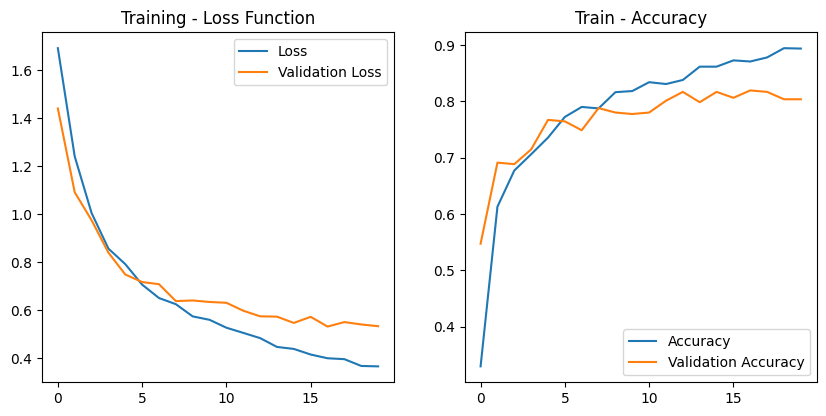

In [13]:
# Plot the training history
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [50]:
# Transfer model performance
score = cnn_model.evaluate(x_test,y_test_encoded,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

y_pred = cnn_model.predict(x_test)
y_pred_indices = np.argmax(y_pred, axis=1)
print("Classification Report:", metrics.classification_report(y_test_encoded, y_pred_indices))
print("Confusion Matrix:", metrics.confusion_matrix(y_test_encoded, y_pred_indices))

Test Loss : 0.5214
Test Accuracy : 0.8243
15/15 [==============================] - 1s 21ms/step
Classification Report:               precision    recall  f1-score   support

           0       0.86      0.80      0.83        80
           1       0.60      0.91      0.72        80
           2       1.00      0.88      0.94        78
           3       0.77      0.71      0.74        80
           4       0.97      0.97      0.97        80
           5       0.90      0.66      0.76        80

    accuracy                           0.82       478
   macro avg       0.85      0.82      0.83       478
weighted avg       0.85      0.82      0.83       478

Confusion Matrix: [[64  6  0 10  0  0]
 [ 1 73  0  4  2  0]
 [ 0  4 69  0  0  5]
 [ 8 14  0 57  0  1]
 [ 0  0  0  2 78  0]
 [ 1 25  0  1  0 53]]


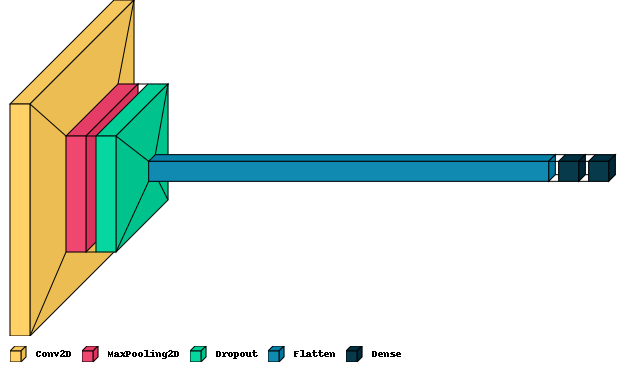

In [15]:
# Visualize model
visualkeras.layered_view(cnn_model, legend=True)

In [31]:
plot_model(cnn_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Transfer Learning: EfficientNetB7

In [20]:
# Load in base model
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(80, 60, 3))
print(len(base_model.layers))

814


In [21]:
# freeze certain layers
for layer in base_model.layers[:810]:
    layer.trainable = False

In [36]:
#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating and compile the final model 
final_model = Model(base_model.input, predictions)
final_model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(lr=0.01), metrics=["accuracy"])
history = final_model.fit(x_train, y_train_encoded, 
                    batch_size=20, epochs=20,verbose=1,
                    validation_split = 0.2)

Epoch 1/20
77/77 [==============================] - 50s 407ms/step - loss: 2.1749 - accuracy: 0.1936 - val_loss: 1.8306 - val_accuracy: 0.1571
Epoch 2/20
77/77 [==============================] - 11s 142ms/step - loss: 1.7704 - accuracy: 0.1909 - val_loss: 1.7697 - val_accuracy: 0.1859
Epoch 3/20
77/77 [==============================] - 12s 151ms/step - loss: 1.7582 - accuracy: 0.2034 - val_loss: 1.7321 - val_accuracy: 0.1806
Epoch 4/20
77/77 [==============================] - 10s 126ms/step - loss: 1.7475 - accuracy: 0.1955 - val_loss: 1.7639 - val_accuracy: 0.1859
Epoch 5/20
77/77 [==============================] - 10s 130ms/step - loss: 1.7504 - accuracy: 0.2034 - val_loss: 1.7302 - val_accuracy: 0.1806
Epoch 6/20
77/77 [==============================] - 11s 141ms/step - loss: 1.7349 - accuracy: 0.2080 - val_loss: 1.7179 - val_accuracy: 0.1832
Epoch 7/20
77/77 [==============================] - 12s 151ms/step - loss: 1.7325 - accuracy: 0.2119 - val_loss: 1.7259 - val_accuracy: 0.1571

Text(0.5, 1.0, 'Train - Accuracy')

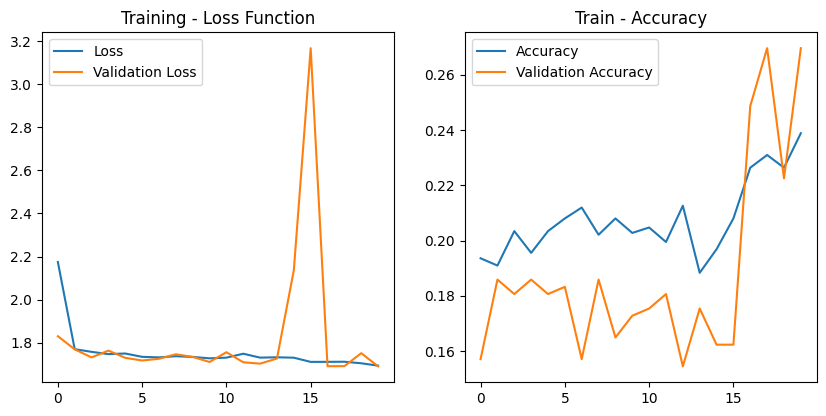

In [37]:
# Plot the training history
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [49]:
# Transfer model performance
score = final_model.evaluate(x_test,y_test_encoded,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

y_pred = final_model.predict(x_test)
y_pred_indices = np.argmax(y_pred, axis=1)
print("Classification Report:", metrics.classification_report(y_test_encoded, y_pred_indices))
print("Confusion Matrix:", metrics.confusion_matrix(y_test_encoded, y_pred_indices))

Test Loss : 1.6943
Test Accuracy : 0.2490
15/15 [==============================] - 2s 111ms/step
Classification Report:               precision    recall  f1-score   support

           0       0.44      0.42      0.43        80
           1       0.20      0.93      0.33        80
           2       0.00      0.00      0.00        78
           3       0.00      0.00      0.00        80
           4       0.31      0.14      0.19        80
           5       0.00      0.00      0.00        80

    accuracy                           0.25       478
   macro avg       0.16      0.25      0.16       478
weighted avg       0.16      0.25      0.16       478

Confusion Matrix: [[34 34  0  0 12  0]
 [ 2 74  0  0  4  0]
 [ 7 68  0  0  3  0]
 [ 9 68  0  0  3  0]
 [22 47  0  0 11  0]
 [ 3 75  0  0  2  0]]
